In [1]:
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import *
from keras.models import Sequential, Model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import random
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
max_length = 129270
epochs = 20
import seaborn as sn

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=9620//3)])
  except RuntimeError as e:
    print(e)

In [3]:
tsv_path = './cv-corpus-12.0-delta-2022-12-07/en/validated.tsv'

In [22]:
df = pd.read_table(tsv_path)
df

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment
0,0277a1e08f90eababc0042d066dc2a67dad837ea38c7a3...,common_voice_en_35244283.mp3,"He was commonly referred to as the ""Blacksmith...",2,0,NaN,NaN,NaN,en,NaN
1,02989caf9972c52df171813798df5c6f4043af96657d32...,common_voice_en_35387333.mp3,No one else could claim that.,2,0,NaN,NaN,NaN,en,NaN
2,030e18361c6f9506b86215891b722f6d9b3b3e48be2cda...,common_voice_en_35273538.mp3,The game was also released on the N-Gage.,2,0,NaN,NaN,NaN,en,NaN
3,05a2ad5cabbd42ef949ed66a3708f34be0e7941b1a9a06...,common_voice_en_35003570.mp3,Her father was an alderman in the city governm...,2,0,NaN,NaN,NaN,en,NaN
4,05a3f4067ed4753da9f9d9d4cd23e51c94e4cd1f62adb8...,common_voice_en_35123560.mp3,The film and each of its vignettes revolve clo...,2,0,NaN,NaN,NaN,en,NaN
...,...,...,...,...,...,...,...,...,...,...
6712,f55a837f1dcff9be74f291521ca3af019920f9357bf021...,common_voice_en_35341669.mp3,"Deja was born in Poland, but moved with his fa...",2,0,thirties,female,United States English,en,NaN
6713,f55a837f1dcff9be74f291521ca3af019920f9357bf021...,common_voice_en_35341687.mp3,His breakthrough performances led him to be la...,2,0,thirties,female,United States English,en,NaN
6714,f55a837f1dcff9be74f291521ca3af019920f9357bf021...,common_voice_en_35341714.mp3,"It was originally titled ""Flippy"" until Sega e...",2,0,thirties,female,United States English,en,NaN
6715,f55a837f1dcff9be74f291521ca3af019920f9357bf021...,common_voice_en_35341715.mp3,It is a very simple format to manually mark up.,4,0,thirties,female,United States English,en,NaN


In [4]:
df = pd.read_table(tsv_path)
df = df.drop(['client_id',  'sentence', 'up_votes', 'down_votes', 'age', 'accents', 'locale', 'segment'], axis=1)

df = df.to_numpy()

audio_list_males = []
audio_list_females = []


for i in range(len(df)):
    if df[i][1] == 'male':
        audio_list_males.append(df[i][0])
    elif df[i][1] == 'female':
        audio_list_females.append(df[i][0])

In [5]:
audio_list_males = audio_list_males[0:len(audio_list_females)]

print(len(audio_list_males), 'males')
print(len(audio_list_females), 'females')

1653 males
1653 females


In [6]:
audio_list = audio_list_males + audio_list_females
audio_labels = []
for i in range(len(audio_list_males)):
    audio_labels.append(1)

for i in range(len(audio_list_females)):
    audio_labels.append(0)

In [7]:
len(audio_list)

3306

In [8]:
X_train, X_test, y_train, y_test = train_test_split(audio_list, audio_labels, test_size=0.1, random_state=42)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
def padarray(A, size):
    t = size - len(A)
    return np.pad(A, pad_width=(0, t), mode='constant')


(129270,)
(501, 518)


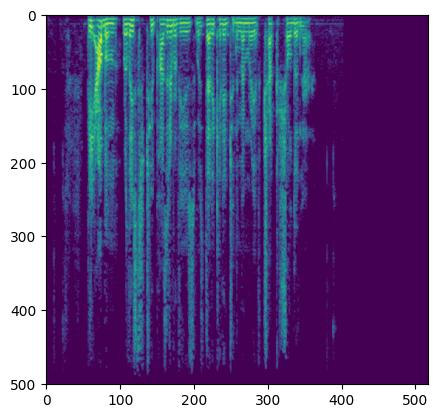

In [24]:
audio_path = './cv-corpus-12.0-delta-2022-12-07/en/clips/'

y, sr = librosa.load(audio_path+audio_list[1], sr=16000)

shape = y.shape[0]


if shape < max_length:
    y = padarray(y, max_length)

y = y[0:max_length]

stft = librosa.stft(y,  n_fft=1000)
db_scaled = librosa.amplitude_to_db(np.abs(stft))

plt.imshow(db_scaled)

print(y.shape)

print(stft.shape)

In [18]:
batch_size = 4
def loader(audio_list, audio_list_labels):
    
    audio_path = './cv-corpus-12.0-delta-2022-12-07/en/clips/'
    
    L = len(audio_list)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            z = np.zeros((len(audio_list[batch_start:limit]), 501, 518))
            for i, f in enumerate(audio_list[batch_start:limit]):
                
                y, sr = librosa.load(audio_path+f, sr=16000)
                
                

                shape = y.shape[0]


                if shape < max_length:
                    y = padarray(y, max_length)

                y = y[0:max_length]

                stft = librosa.stft(y,  n_fft=1000)
                
                stft = librosa.util.normalize(stft)
                
                stft = np.real(stft)
                
                z[i, :, :] = stft

            X = np.expand_dims(z, axis=-1)
            Y = np.array(audio_list_labels[batch_start:limit])
            yield (X,Y)
            batch_start += batch_size   
            batch_end += batch_size
            
train_loader = loader(X_train, y_train)
val_loader = loader(X_val, y_val)

In [19]:
x, y = train_loader.__next__()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 501, 518, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 507, 524, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 251, 259, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

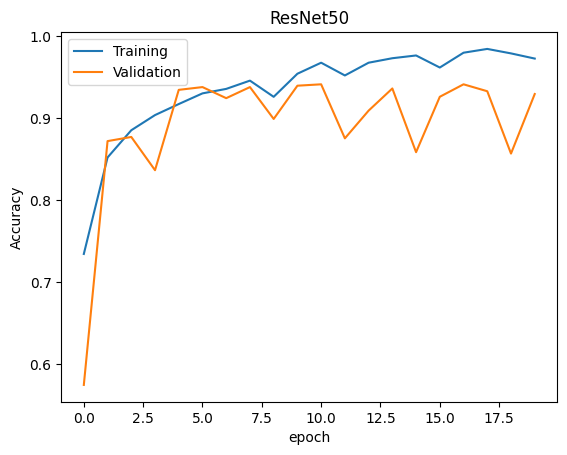

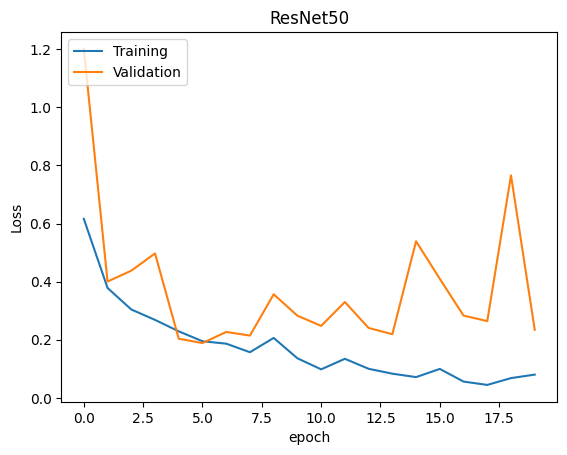

For ResNet50
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       148
           1       0.95      0.97      0.96       183

    accuracy                           0.95       331
   macro avg       0.96      0.95      0.95       331
weighted avg       0.95      0.95      0.95       331

0.9546827794561934


<Axes: >

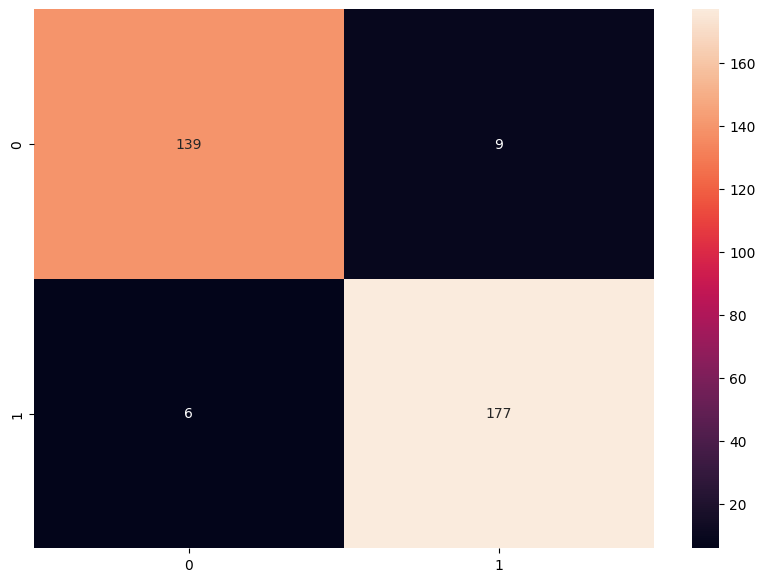

In [20]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(501, 518, 1),
    pooling=None,
)
resnet50.summary()

model = Sequential()
model.add(resnet50)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
)

metrics = ['accuracy']
optimizer = Adam(0.001)

media_start = './'

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=20,
    verbose=1,
    mode="auto"
)

filepath= media_start+"resnet50.hdf5"

checkpoint = ModelCheckpoint(filepath, save_freq="epoch",save_best_only=True,
    save_weights_only=True, monitor='val_accuracy', verbose=1)

csv_logger = CSVLogger(media_start+"resnet50-log.csv")


model.compile(optimizer = optimizer, loss=loss, metrics=metrics)

train_steps = len(X_train)//batch_size
val_steps = len(X_val)//batch_size



history = model.fit(train_loader, 
                    steps_per_epoch=train_steps, 
                    epochs=epochs, verbose=1, 
                    validation_data=val_loader, 
                    validation_steps=val_steps, 
                    callbacks=[checkpoint, csv_logger]
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Loading best model weights
model.load_weights('resnet50.hdf5')

predictions = np.zeros((len(X_test), 2))

for i, f in enumerate(X_test):
    y, sr = librosa.load(audio_path+f, sr=16000)



    shape = y.shape[0]


    if shape < max_length:
        y = padarray(y, max_length)

    y = y[0:max_length]

    stft = librosa.stft(y, n_fft=1000)

    stft = librosa.util.normalize(stft)

    stft = np.real(stft)
    
    data = stft
    data = np.expand_dims(np.expand_dims(data, axis=-1), axis=0)
    p = model.predict(data, verbose=0)
    predictions[i, :] = p
    
print("For ResNet50")
y_pred = np.argmax(predictions, axis=1)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plt.figure(figsize = (10,7))
cm = confusion_matrix(y_test, y_pred)
sn.heatmap(cm, annot=True, fmt=".0f")

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 501, 518, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 501, 518, 1)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 501, 518, 1)  3           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 503, 519, 1)  0           ['normalization[0][0

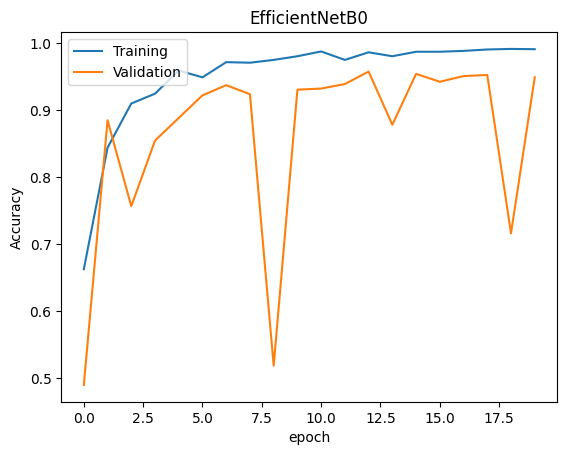

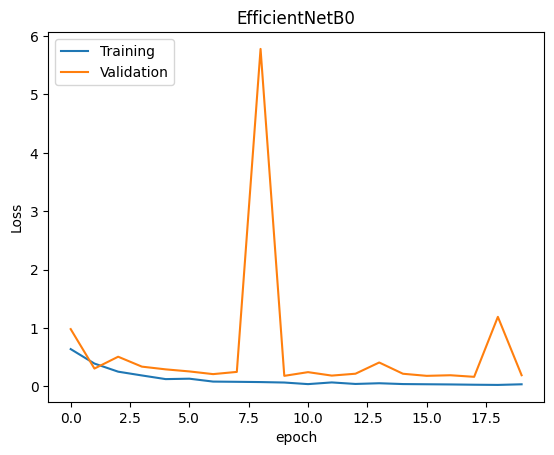

For EfficientNetB0
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       148
           1       0.98      0.97      0.97       183

    accuracy                           0.97       331
   macro avg       0.97      0.97      0.97       331
weighted avg       0.97      0.97      0.97       331

0.9697885196374623


<Axes: >

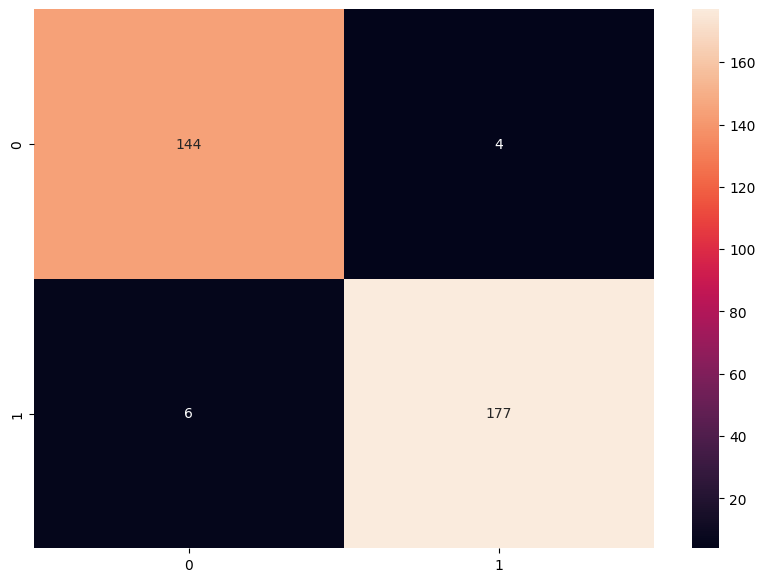

In [21]:
EfficientNetB0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,
    input_shape=(501, 518, 1),
    pooling=None,
)
EfficientNetB0.summary()

model = Sequential()
model.add(EfficientNetB0)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
)

metrics = ['accuracy']
optimizer = Adam(0.001)

media_start = './'

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=20,
    verbose=1,
    mode="auto"
)

filepath= media_start+"EfficientNetB0.hdf5"

checkpoint = ModelCheckpoint(filepath, save_freq="epoch",save_best_only=True,
    save_weights_only=True, monitor='val_accuracy', verbose=1)

csv_logger = CSVLogger(media_start+"vgg-log.csv")


model.compile(optimizer = optimizer, loss=loss, metrics=metrics)

train_steps = len(X_train)//batch_size
val_steps = len(X_val)//batch_size



history = model.fit(train_loader,
        steps_per_epoch=train_steps,
        epochs=epochs,
        verbose=1,
        validation_data=val_loader,
        validation_steps=val_steps,
        callbacks=[checkpoint, csv_logger]
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('EfficientNetB0')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('EfficientNetB0')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

# Loading best model weights
model.load_weights('EfficientNetB0.hdf5')

predictions = np.zeros((len(X_test), 2))

for i, f in enumerate(X_test):
    y, sr = librosa.load(audio_path+f, sr=16000)



    shape = y.shape[0]


    if shape < max_length:
        y = padarray(y, max_length)

    y = y[0:max_length]

    stft = librosa.stft(y, n_fft=1000)

    stft = librosa.util.normalize(stft)

    stft = np.real(stft)
    
    data = stft
    data = np.expand_dims(np.expand_dims(data, axis=-1), axis=0)
    p = model.predict(data, verbose=0)
    predictions[i, :] = p
    
print("For EfficientNetB0")
y_pred = np.argmax(predictions, axis=1)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plt.figure(figsize = (10,7))
cm = confusion_matrix(y_test, y_pred)
sn.heatmap(cm, annot=True, fmt=".0f")